In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import resting_state_summaries as rss
from nilearn.image import load_img, new_img_like
import nilearn.plotting as plotting

In [2]:
atlas = load_img('Schaefer2018_200Parcels_17Networks_order_FSLMNI152_2mm.nii.gz')
def vec_to_img(vec):
    n_rois = 200
    atlas_data = atlas.get_fdata()

    vec_img_data = np.zeros_like(atlas_data)
    for idx_roi in range(n_rois):
        vec_img_data += (atlas_data==idx_roi+1) * vec[idx_roi]

    vec_img = new_img_like(data=vec_img_data, ref_niimg=atlas)
    return vec_img

In [3]:
K = 6
D = 10
with open('Final_model/K6_D10_500subjs_compact_model.pkl', 'rb') as f:
    [model, q, elbos, q_z] = pickle.load(f)

num_roi = model.N
num_subject = len(np.unique(model.tags))
pid = np.unique(model.tags)

/home/xzhou126/miniconda3/envs/slds/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
with open('data/roi_timeseries_rsfMRI_HCP_held_out', 'rb') as f:
    datas = pickle.load(f)
with open('data/tags_rsfMRI_HCP_held_out', 'rb') as f:
    tags = pickle.load(f)
datas_fitted = [datas[i] for i in range(len(datas)) if tags[i] in pid]  
tags_fitted = list(np.concatenate([np.repeat(pid[l], 4) for l in range(len(pid))]))

state segments

In [5]:
# get subject timeseries and state labels 
y_subject = dict()
z_subject = dict()
for s in range(num_subject):
    y_subject[s] = np.concatenate([datas[i] for i in range(len(datas)) if tags[i] == pid[s]])  
    z_subject[s] = [q_z[i] for i in range(len(datas)) if tags[i] == pid[s]]
z_bundle_subject = dict()
y_bundle_subject = dict()
for s in range(num_subject):
    z_bundle_subject[s] = rss.collect_z_bundle(z_subject[s])
    y_bundle_subject[s] = rss.collect_y_bundle(y_subject[s], z_bundle_subject[s], K)

In [6]:
z_bundles = [z_bundle_subject[i][j] for i in range(num_subject) for j in range(len(z_bundle_subject[i]))]

In [7]:
# concatenate subject state timeseries segments 
y_bundles = dict()
for k in range(K):
    y_bundles[k] = []
    for s in range(num_subject):
        for j in range(len(y_bundle_subject[s][k])):
            y_bundles[k].append(y_bundle_subject[s][k][j])

In [8]:
activity_evolution = rss.activity_evolution(y_bundles, T = 30)   # ~8min

In [ ]:
activity_evolution_subject = [rss.activity_evolution(y_bundle_subject[s], T = 30) for s in range(num_subject)] # ~9min

In [ ]:
# with open('summary_data/roi_activity_evolution.pkl','wb') as f:
#      pickle.dump(activity_evolution, f)
# with open('summary_data/roi_activity_evolution_subject.pkl','wb') as f:
#      pickle.dump(activity_evolution_subject, f)

In [10]:
state_duration = rss.compute_state_duration(z_bundles, K, method = 'mean')  # group-level
# order states by mean duration
state_order = np.argsort(state_duration)[::-1]
# use integer duration for later analysis
state_duration = np.array(state_duration, dtype = int)

In [11]:
def compute_auc(activity_evolution, T = 5): 
    num_roi = len(activity_evolution)
    auc = np.zeros(num_roi)
    for j in range(num_roi):
        auc[j] = np.mean(activity_evolution[j][1:(T+1)])-activity_evolution[j][0]
    return auc

In [12]:
state_auc = np.zeros((K, num_roi))
for k in range(K):
    state = state_order[k]
    state_auc[k,:] = compute_auc(activity_evolution[state], T = state_duration[state])

In [13]:
state_auc_subject = dict()
for s in range(num_subject):
    state_auc_subject[s] = np.zeros((K, num_roi))
    for k in range(K):
        state = state_order[k]
        state_auc_subject[s][k,:] = compute_auc(activity_evolution_subject[s][state], T = state_duration[state])

test state auc = 0

In [14]:
import scipy
mu_0 = 0
pvalues = np.zeros((K, num_roi))
test_stats = np.zeros((K, num_roi))
for k in range(K):
    for i in range(num_roi):
        vec = [state_auc_subject[s][k,i] for s in range(num_subject)]
        N = num_subject-np.sum(np.isnan(vec)) # number of subjects which have state k trajectories until mean duration (so auc is not nan)
        test_stats[k,i] = np.sqrt(N)*(np.nanmean(vec)-mu_0)/np.nanstd(vec)
        df = N-1
        pvalues[k,i] = 2*scipy.stats.t.sf(np.abs(test_stats[k,i]), df)

In [15]:
pvalues_corrected = scipy.stats.false_discovery_control(pvalues)

In [ ]:
rejection_mat = np.zeros((K, num_roi))
# whole-brain test
rejection_mat = pvalues_corrected<0.05

expected activity at late times in state (use mean duration + 3 TR)

In [17]:
late_map = np.zeros((K,num_roi))
for k in range(K):
    T = state_duration[k]+3
    for i in range(num_roi):
        late_map[k,i] = activity_evolution[k][i][T]

In [18]:
with open('state_activity_map.pkl','wb') as f:
     pickle.dump(late_map, f)
with open('state_activity_map_rejection_mat.pkl','wb') as f:
     pickle.dump(rejection_mat, f)

cortical surface maps (thresholded)

In [44]:
from PIL import Image,ImageChops
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    #Bounding box given as a 4-tuple defining the left, upper, right, and lower pixel coordinates.
    #If the image is completely empty, this method returns None.
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    
def join_2x2(imgs, out_path, dpi=300, padding=20):
    if len(imgs) != 4:
        raise ValueError("Need exactly 4 images in order: TL, TR, BL, BR")

    w1, h1 = imgs[0].size
    w2, h2 = imgs[1].size
    w3, h3 = imgs[2].size
    w4, h4 = imgs[3].size

    top_row_h = max(h1, h2)
    bottom_row_h = max(h3, h4)
    total_w = max(w1+w2,w3+w4) + padding
    total_h = top_row_h + bottom_row_h + padding

    grid = Image.new("RGBA", (total_w, total_h), (0, 0, 0, 0))
    grid.paste(imgs[0], (0, 0))
    grid.paste(imgs[1], (w1+padding, 0))
    grid.paste(imgs[2], (0, top_row_h+padding))
    grid.paste(imgs[3], (w3+padding, top_row_h+padding))

    grid.save(out_path, dpi=(dpi, dpi))

In [ ]:
for k in range(K):
    state = state_order[k]
    vec = late_map[state,:].copy()
    vec[rejection_mat[k,:] == False]  = 0 # put a mask on brain map by rejection_mat
    vec = vec[54:254]
    vec_img = vec_to_img(vec)
    grid = []
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:
            fig,ax = plotting.plot_img_on_surf(
                        vec_img,
                        surf_mesh='fsaverage5', bg_on_data=True, inflate=True,
                        hemispheres=[hemi], views=[view],
                        vmin = -.5, vmax=0.5, 
                        threshold=1e-10,
                        colorbar=False,
                        cmap = 'seismic'
                    )
            fig.set_size_inches(4, 4)
            fig.savefig("maps/late_map_cortex_thresholded/state%s_%s_%s.png"%(k+1, hemi, view), dpi=300, transparent=True)
            plt.close(fig)
            grid.append(trim(Image.open("maps/late_map_cortex_thresholded/state%s_%s_%s.png"%(k+1, hemi, view))))
    join_2x2(grid, "maps/late_map_cortex_thresholded/state%s.png"%(k+1))

contrast map

In [ ]:
# test for pairwise contrast
# if their auc values differ
rejection_vecs = dict()
for k1 in range(K):
    rejection_vecs[k1] = dict()
    for k2 in range(K):
        rejection_vecs[k1][k2] = np.zeros(num_roi)
        
for state1 in range(K):
    for state2 in range(K):
        if state1 == state2:
            continue
        k1 = state_order[state1]
        k2 = state_order[state2]
        pvalues = np.zeros(num_roi)
        test_stats = np.zeros(num_roi)
        # recompute auc up to the smaller mean duration for the two states
        T = min(state_duration[k1], state_duration[k2])
        state_auc_subject_state1 = [compute_auc(activity_evolution_subject[s][k1], T) for s in range(num_subject)]
        state_auc_subject_state2 = [compute_auc(activity_evolution_subject[s][k2], T) for s in range(num_subject)]
        # test
        for i in range(num_roi):
            vec = [state_auc_subject_state1[s][i] - state_auc_subject_state2[s][i] for s in range(num_subject)]
            N = num_subject-np.sum(np.isnan(vec)) 
            test_stats[i] = np.sqrt(N)*(np.nanmean(vec)-mu_0)/np.nanstd(vec)
            df = N-1
            pvalues[i] = 2*scipy.stats.t.sf(np.abs(test_stats[i]), df)
        pvalues_corrected = scipy.stats.false_discovery_control(pvalues)
        rejection_vec = pvalues_corrected<0.05
        rejection_vecs[state1][state2] = rejection_vec

        vec = late_map[k1,:] - late_map[k2,:]
        vec[rejection_vec == False]  = 0
        vec = vec[54:254]
        vec_img = vec_to_img(vec)
        grid = []
        for view in ['lateral', 'medial']:
            for hemi in ['left', 'right']:
                fig,ax = plotting.plot_img_on_surf(
                        vec_img,
                        surf_mesh='fsaverage5', bg_on_data=True, inflate=True,
                        hemispheres=[hemi], views=[view],
                        vmin = -.3, vmax= .3, 
                        threshold=1e-10,
                        colorbar=False,
                        cmap = 'seismic'
                    )
                fig.set_size_inches(4, 4)
                out_file = "maps/contrast_maps/hemi_view/state%s-state%s_%s_%s.png"%(state1+1, state2+1, hemi, view)
                fig.savefig(out_file, dpi=300, transparent=True)
                plt.close(fig)
                grid.append(trim(Image.open(out_file)))
        join_2x2(grid, "maps/contrast_maps/state%s - state%s.png"%(state1+1, state2+1))

In [ ]:
# with open('contrast_map_rejection_vecs.pkl','wb') as f:
#      pickle.dump(rejection_vecs, f)

subcortical maps (thresholded)

In [25]:
atlas = load_img('Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S4_MNI152NLin6Asym_2mm.nii.gz')
def vec_to_img(vec):
    n_rois = 254
    atlas_data = atlas.get_fdata()

    vec_img_data = np.zeros_like(atlas_data)
    for idx_roi in range(n_rois):
        vec_img_data += (atlas_data==idx_roi+1) * vec[idx_roi]

    vec_img = new_img_like(data=vec_img_data, ref_niimg=atlas)
    return vec_img

In [26]:
for k in range(K):
    state = state_order[k]
    vec = late_map[state,:].copy()
    vec[rejection_mat[state,:] == False]  = 0
    vec[54:254] = 0     # set entire cortex to zero, display subcortex only
    vec_img = vec_to_img(vec)
    vec_img.to_filename(f'maps/late_map_subcortex_thresholded/late_map_subcortex_thresholded_state%s.nii.gz'%(k+1))

In [ ]:
# How many subcortical regions survive thresholding?
# with open('state_activity_map_rejection_mat.pkl','rb') as f:
#      rejection_mat = pickle.load(f)
# np.sum(rejection_mat[:, 0:54], axis = 1)

cosine similarity (whole-brain)

In [53]:
cs_late_pt = np.zeros((K, K))
for k1 in range(K):
    for k2 in range(K):
        cs_late_pt[k1,k2] = rss.cosine_similarity(late_map[state_order[k1]], late_map[state_order[k2]])

<Axes: >

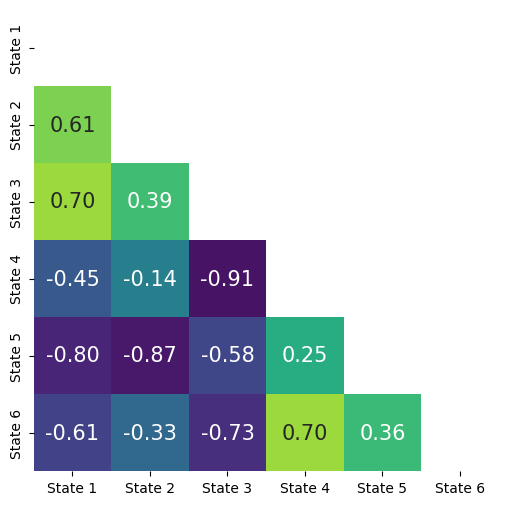

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(K,K))
y_axis_labels = ['State %s'%(k+1) for k in range(K)]
x_axis_labels = ['State %s'%(k+1) for k in range(K)] 
mask = np.triu(np.ones_like(cs_late_pt, dtype=bool), k=0)
sns.heatmap(cs_late_pt, vmin = -1, vmax = 1,  annot=True, fmt='.2f', annot_kws={'size':15}, mask=mask, cbar = False, cmap='viridis',
           xticklabels=x_axis_labels, yticklabels=y_axis_labels)

attractor maps

In [ ]:
C = model.emissions.Cs[0]
d = model.emissions.ds[0]
roi_attractor = []
for k in range(K): 
    attractor = np.linalg.inv(np.identity(D)- model.parent.dynamics.As[k]).dot(model.parent.dynamics.bs[k])
    roi_attractor.append(C.dot(attractor) + d)

In [ ]:
for k in range(K):
    state = state_order[k]
    vec = roi_attractor[state].copy()
    vec_img = vec_to_img(vec[54:254])
    grid = []
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:
            fig,ax = plotting.plot_img_on_surf(
                        vec_img,
                        surf_mesh='fsaverage5', bg_on_data=True, inflate=True,
                        hemispheres=[hemi], views=[view],
                        vmin = -.5, vmax=0.5, 
                        threshold=1e-10,
                        colorbar=False,
                        cmap = 'seismic'
                    )
            fig.set_size_inches(4, 4)
            fig.savefig("maps/attractor_map/state%s_%s_%s.png"%(k+1, hemi, view), dpi=300, transparent=True)
            plt.close(fig)
            grid.append(trim(Image.open("maps/attractor_map/state%s_%s_%s.png"%(k+1, hemi, view))))
    join_2x2(grid, "maps/attractor_map/state%s.png"%(k+1))